In [ ]:
Build Your First Stateful Agent

### Task
Create an agent with three custom tools:
1. **Weather tool:** Returns simulated weather for a given city
2. **Dictionary tool:** Looks up word definitions (simulate with a small dict)
3. **Web search tool:** Uses DuckDuckGo to search the web for information

### Requirements
1. Define tools using `@tool` decorator
2. Bind tools to LLM
3. Implement conditional routing (agent decides which tool to use)
4. Handle cases where no tool is needed
5. Install DuckDuckGo search: `pip install duckduckgo-search`
6. Use `DDGS().text()` method for web searches

### Example Queries
- "What's the weather in Lagos?" → Uses weather tool
- "Define the word 'ephemeral'" → Uses dictionary
- "Search for latest AI news" → Uses DuckDuckGo web search
- "What's the capital of France?" → No tool needed


In [25]:
#  Install required Packages

%pip install -q langchain langgraph langchain-openai python-dotenv requests duckduckgo-search ddgs


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [26]:
# Import Libraries

# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from ddgs import DDGS
from dotenv import load_dotenv
import os
from duckduckgo_search import DDGS
from IPython.display import display, Image

print("✅ All imports successful")



✅ All imports successful


In [27]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("✅ API key loaded")

✅ API key loaded


In [28]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,  # Lower temperature for more precise tool usage
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


In [ ]:
CREATE the tools

In [31]:
# Create weather tool

@tool
def weather_tool(city: str) -> str:
    """Returns current weather for a given place.
        Use when you need to find and/or provide the weather of a place.

        Args:
            city (str): The city to look up.

        Returns:
            str: The weather of the city.

        Examples:
            >>> weather_tool("Paris")
            "The weather in Paris is currently sunny with a temperature of 25°C."
    """
    try:
        weather = DDGS().text(city, max_results=1)
        return weather 
    except Exception as e:
        return f"Weather lookup failed: {e}"
    
print('Weather Fetching tool created successfully')


Weather Fetching tool created successfully


In [32]:
#  create dictionary tool
@tool
def dictionary_tool(word: str) -> str:
    """Looks up the definition of a word.
        Use when you need to find and/or provide the meaning of a word in the dictionary.

        Args:
            word (str): The word to look up.

        Returns:
            str: The definition of the word.

        Examples:
            >>> dictionary_tool("ephemeral")
            "lasting for a very short time."
            >>> dictionary_tool("agent")
            "something that acts or exerts power."
            >>> dictionary_tool("langgraph")
            "a library for building stateful, multi-actor applications with LLMs."
    """
    try:
        definition = DDGS().text(word, max_results=1)
        return definition 
    except Exception as e:
        return f"Definition failed: {e}"

print('Dictionary Fetching tool created successfully')

Dictionary Fetching tool created successfully


In [33]:
# create  web search tool

@tool
def web_search_tool(query: str) -> str:
    """Performs a web search using DuckDuckGo.
        Use when you need to search for up-to-date information on the web.

        Args:
            query (str): The search query.

        Returns:
            str: The search results.

        Examples:
            >>> web_search_tool("What is the capital of France?")
            "The capital of France is Paris."
    """
    try:
        # Using DDGS().text()
        results = DDGS().text(query, max_results=3)
        if not results:
            return "No results found."
        formatted_results = "\n\n".join([f"Title: {r['title']}\nLink: {r['href']}\nSnippet: {r['body']}" for r in results])
        return formatted_results
    except Exception as e:
        return f"Search failed: {e}"

tools = [weather_tool, dictionary_tool, web_search_tool]

print('Dictionary Fetching tool created successfully')


Dictionary Fetching tool created successfully


In [34]:
# Bind the tools
llm_with_tools = llm.bind_tools(tools)

print(f"✅ LLM bound to {len(tools)} tools")
print(f"   Tools: {[tool.name for tool in tools]}")

✅ LLM bound to 3 tools
   Tools: ['weather_tool', 'dictionary_tool', 'web_search_tool']


✅ Agent graph compiled successfully


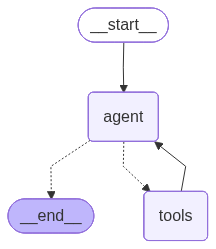

In [ ]:
# Define the system message
sys_msg = SystemMessage(content="You are a helpful assistance. You have access to weather, dictionary, and web search tools. Use them when necessary to answer user queries.")

# Define the agent(assistance) node
def agent(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# create the graph
graph = StateGraph(MessagesState)

# Add nodes
graph.add_node("agent", agent)
graph.add_node("tools", ToolNode(tools))

# Add edges
graph.add_edge(START, "agent")
graph.add_conditional_edges("agent", tools_condition)
graph.add_edge("tools", "agent")

# Compile the graph
agent = graph.compile()

print("✅ Agent graph compiled successfully")

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [42]:
# Test the Agent

# Helper Function
def run_assistant(user_input: str, thread_id: str = 'test_session'):
    """
    Run the agent and display the conversation.
    """
    print(f"\n{'='*100}")
    print(f'User: {user_input}')
    print(f"{'='*70}\n")


    result = agent.invoke(
        {"messages":[HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )

    for msg in result["messages"]:
        if isinstance(msg, HumanMessage):
            continue
        elif isinstance(msg, AIMessage):
            if msg.tool_calls:
                print(f"Agent: [Calling tool: {msg.tool_calls[0]['name']}]")
            else: 
                print(f'Tool Result: {msg.content[:100]}...' if len(msg.content) > 100 else f"Tool Result: {msg.content}")
print("✅ Test function ready")


✅ Test function ready


In [45]:
# Test weather function
run_assistant('What is the weather in Lagos?')



User: What is the weather in Lagos?



C:\Users\hp\AppData\Local\Temp\ipykernel_2076\2956798365.py:19: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  weather = DDGS().text(city, max_results=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_2076\2956798365.py:19: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  weather = DDGS().text(city, max_results=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_2076\2956798365.py:19: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  weather = DDGS().text(city, max_results=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_2076\2956798365.py:19: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  weather = DDGS().text(city, max_results=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_2076\2956798365.py:19: RuntimeWarning: This package (`duckduckgo_search`) has b

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/GRAPH_RECURSION_LIMIT